In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from statsmodels.nonparametric.smoothers_lowess import lowess
import pywt
import os
from scipy.signal import butter, filtfilt
from scipy.signal import detrend
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from scipy.signal import welch
from scipy.signal.windows import hann
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu


### **1.**  Robust LOESS y Non Local Means

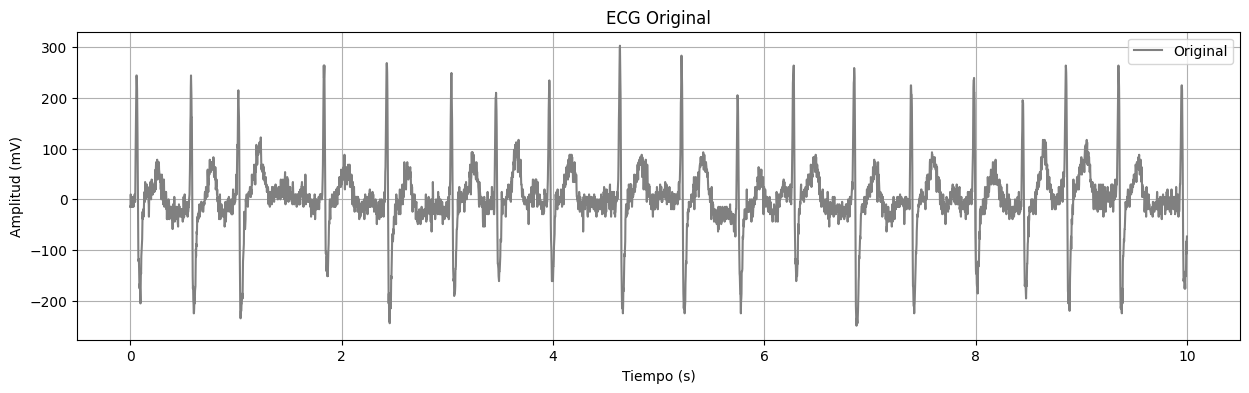

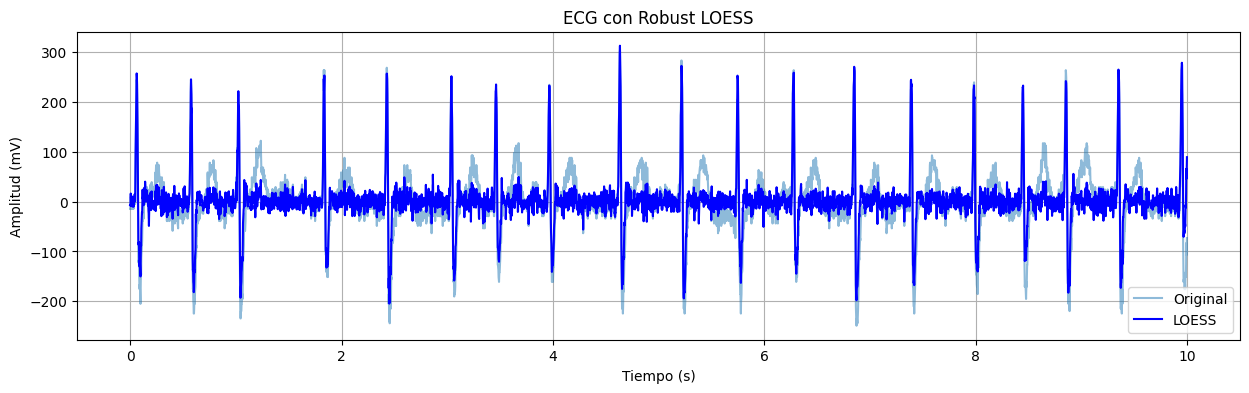

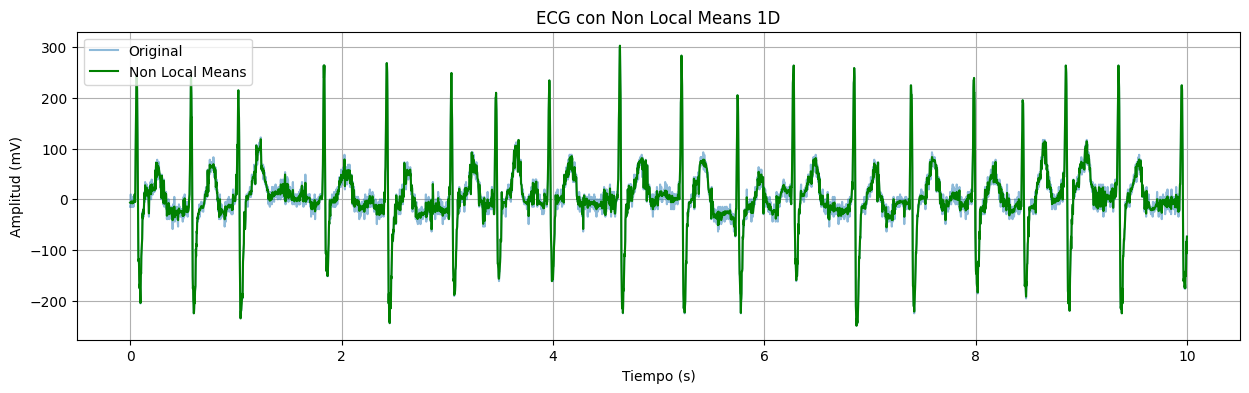

In [2]:
# Función Non Local Means 1D
def nlm_1d(signal, h=1.0, patch_size=5, search_window=15):
    N = len(signal)
    denoised = np.zeros_like(signal)
    weights_sum = np.zeros_like(signal)

    for i in range(N):
        patch_i = signal[max(0, i - patch_size):min(N, i + patch_size + 1)]
        for j in range(max(0, i - search_window), min(N, i + search_window + 1)):
            patch_j = signal[max(0, j - patch_size):min(N, j + patch_size + 1)]
            min_len = min(len(patch_i), len(patch_j))
            dist2 = np.sum((patch_i[:min_len] - patch_j[:min_len])**2)
            weight = np.exp(-dist2 / (h ** 2))
            denoised[i] += weight * signal[j]
            weights_sum[i] += weight
    return denoised / weights_sum

def filtro_loess(ecg, frac=0.01, it=3):
    x = np.arange(len(ecg))
    tendencia = lowess(ecg, x, frac=frac, it=it, return_sorted=False)
    ecg_sin_tendencia = ecg - tendencia
    return ecg_sin_tendencia, tendencia


# Parámetros
muestreo_hz = 500
muestras_mostrar = 5000
directorio_parquet = './data/processed_filter/parquet/AFIB'

# Señal sin filtrar
archivo = glob.glob(f"{directorio_parquet}/*.parquet")[0]
df = pd.read_parquet(archivo)
df.columns = ['timestamp', 'ecg_signal']
ecg = df['ecg_signal'].values[:muestras_mostrar]
tiempo = np.arange(len(ecg)) / muestreo_hz

# Filtro LOESS
ecg_loess, tendencia = filtro_loess(ecg)

# Filtro Non Local Means
ecg_nlm = nlm_1d(ecg, h=0.5 * np.std(ecg))

# Graficar original
plt.figure(figsize=(15, 4))
plt.plot(tiempo, ecg, label='Original', color='gray')
plt.title('ECG Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (mV)')
plt.grid(True)
plt.legend()
plt.show()

# Graficar LOESS
plt.figure(figsize=(15, 4))
plt.plot(tiempo, ecg, label='Original', alpha=0.5)
plt.plot(tiempo, ecg_loess, label='LOESS', color='blue')
plt.title('ECG con Robust LOESS')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (mV)')
plt.grid(True)
plt.legend()
plt.show()

# Graficar NLM
plt.figure(figsize=(15, 4))
plt.plot(tiempo, ecg, label='Original', alpha=0.5)
plt.plot(tiempo, ecg_nlm, label='Non Local Means', color='green')
plt.title('ECG con Non Local Means 1D')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (mV)')
plt.grid(True)
plt.legend()
plt.show()


### **2.** Extracción derivación II 


Estructura del archivo: 2 columnas, 5000 muestras
Primeras filas:
   timestamp     II
0          0 -24.40
1          1 -43.92
2          2 -24.40
3          3  -4.88
4          4 -14.64


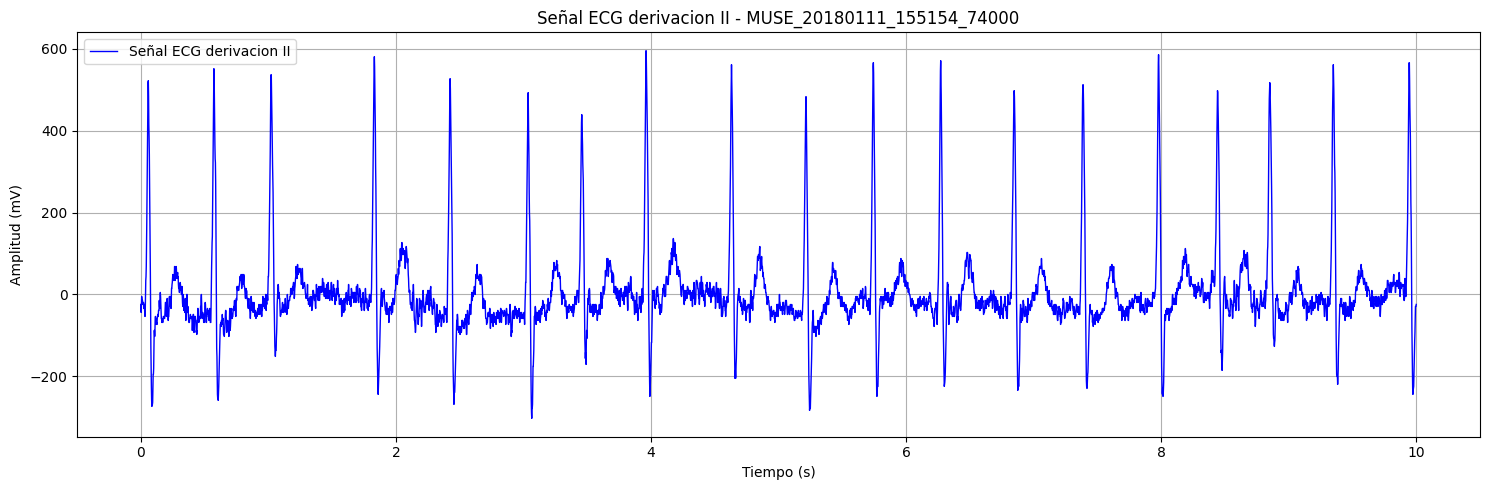

In [3]:
'''Inspeccion de la señal para la derivacion II'''
# Datos
muestreo_hz = 500 # Dicho de donde se tomaron las señales para el trabajo
muestras_mostrar = 5000  # Muestras a visualizar
directorio_parquet = './data/processed_dii/parquet/AFIB'

# Cargamos el archivos Parquet
archivos_parquet = glob.glob(f"{directorio_parquet}/*.parquet")[:1]  # Primer archivo

if not archivos_parquet:
    raise FileNotFoundError("No se encontraron archivos Parquet") # Verificar que no este vacio la carpeta

# Procesar los archivos .parquet
def procesar_ecg(archivo_parquet):
    # Leemos el archivo
    df = pd.read_parquet(archivo_parquet)
    
    # Verificamos la estructura
    print(f"\nEstructura del archivo: {df.shape[1]} columnas, {df.shape[0]} muestras")
    print("Primeras filas:")
    print(df.head())
    
    # Estructura
    if df.shape[1] == 2:
        # columnas del dataframe
        df.columns = ['timestamp', 'II']
        # señal
        señal = df['II'].values[:muestras_mostrar]
        tiempo = np.arange(len(señal)) / muestreo_hz
        
        # Grafica:
        plt.figure(figsize=(15, 5))
        plt.plot(tiempo, señal, label='Señal ECG derivacion II', linewidth=1, color='blue')
        plt.title(f'Señal ECG derivacion II - {Path(archivo_parquet).stem}')
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Amplitud (mV)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        return df, señal
    
    else:
        raise ValueError("Estructura de archivo no reconocida")


df_ecg, señal = procesar_ecg(archivos_parquet[0])

 ### **3.** Señales wavelet
 #### **3.1** Daubechies (db6)

Archivo cargado: ./data/processed_dii/parquet/AFIB\MUSE_20180111_155154_74000.parquet
Columnas disponibles: Index(['timestamp', 'II'], dtype='object')


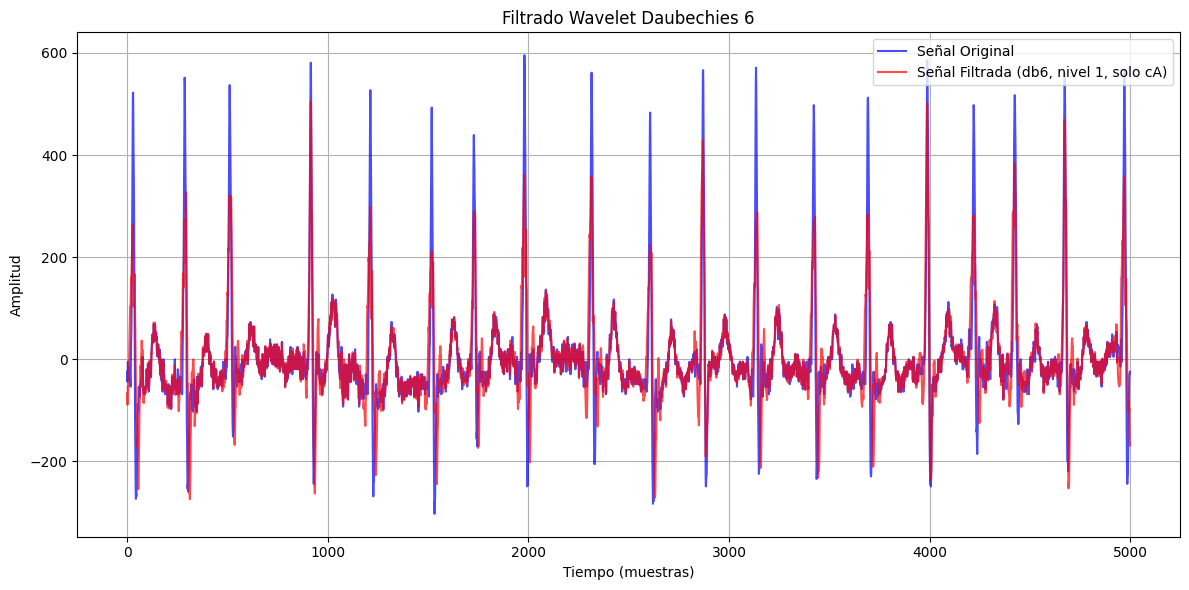

In [4]:
# Parámetros dados
muestreo_hz = 500
muestras_mostrar = 5000
directorio_parquet = './data/processed_dii/parquet/AFIB'

# Buscar el primer archivo .parquet en el directorio
archivos = [f for f in os.listdir(directorio_parquet) if f.endswith('.parquet')]
archivo_parquet = os.path.join(directorio_parquet, archivos[0])

# Cargar el archivo parquet
df = pd.read_parquet(archivo_parquet)
print(f"Archivo cargado: {archivo_parquet}")
print(f"Columnas disponibles: {df.columns}")

# Señal a procesar
columna_senal = 'II' if 'II' in df.columns else df.columns[0]
senal = df[columna_senal].values[:muestras_mostrar]

# Descomposición Wavelet
wavelet = 'db6'
nivel = 4
coeffs = pywt.wavedec(senal, wavelet=wavelet, level=nivel)

# Eliminar los detalles de nivel 1 (alta frecuencia)
coeffs[1] = np.zeros_like(coeffs[1])  # cD1

# Reconstrucción de la señal solo con la aproximación (cA1)
senal_filtrada = pywt.waverec(coeffs, wavelet)
senal_filtrada = senal_filtrada[:len(senal)]  # Ajuste por padding

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(senal, label='Señal Original', color='blue', alpha=0.7)
plt.plot(senal_filtrada, label='Señal Filtrada (db6, nivel 1, solo cA)', color='red', alpha=0.7)
plt.title('Filtrado Wavelet Daubechies 6')
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#### **3.2** Symlet (sym6)


Archivo cargado: ./data/processed_dii/parquet/AFIB\MUSE_20180111_155154_74000.parquet
Columnas disponibles: Index(['timestamp', 'II'], dtype='object')


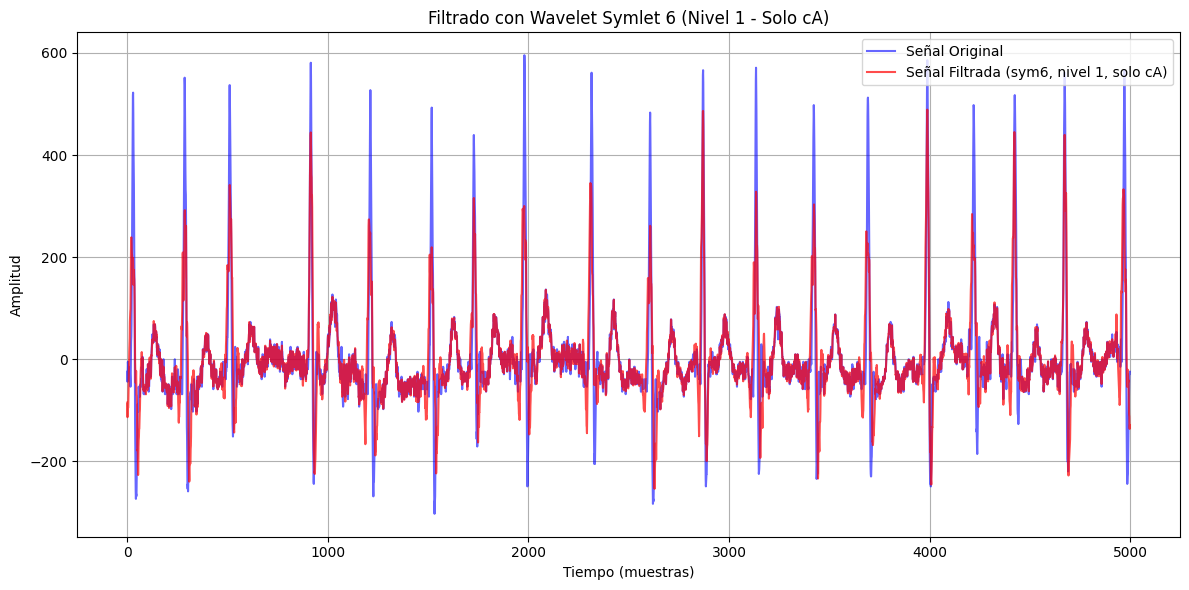

In [5]:
# Parámetros
muestreo_hz = 500
muestras_mostrar = 5000
directorio_parquet = './data/processed_dii/parquet/AFIB'

# Cargar el primer archivo .parquet del directorio
archivos = [f for f in os.listdir(directorio_parquet) if f.endswith('.parquet')]
archivo_parquet = os.path.join(directorio_parquet, archivos[0])

# Leer el archivo .parquet
df = pd.read_parquet(archivo_parquet)
print(f"Archivo cargado: {archivo_parquet}")
print(f"Columnas disponibles: {df.columns}")

# Seleccionar columna de señal
columna_senal = 'II' if 'II' in df.columns else df.columns[0]
senal = df[columna_senal].values[:muestras_mostrar]

# Aplicar transformada wavelet (Symlet 6) con nivel 1
wavelet = 'sym6'
nivel = 4
coeffs = pywt.wavedec(senal, wavelet=wavelet, level=nivel)

# Eliminar detalles (alta frecuencia) del nivel 1
coeffs[1] = np.zeros_like(coeffs[1])  # Eliminar cD1

# Reconstrucción de la señal usando solo cA1
senal_filtrada = pywt.waverec(coeffs, wavelet)
senal_filtrada = senal_filtrada[:len(senal)]  # Ajustar longitud por padding

# Visualización
plt.figure(figsize=(12, 6))
plt.plot(senal, label='Señal Original', color='blue', alpha=0.6)
plt.plot(senal_filtrada, label='Señal Filtrada (sym6, nivel 1, solo cA)', color='red', alpha=0.7)
plt.title('Filtrado con Wavelet Symlet 6 (Nivel 1 - Solo cA)')
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### **3.3** Haar

Archivo cargado: ./data/processed_dii/parquet/AFIB\MUSE_20180111_155154_74000.parquet
Columnas disponibles: Index(['timestamp', 'II'], dtype='object')


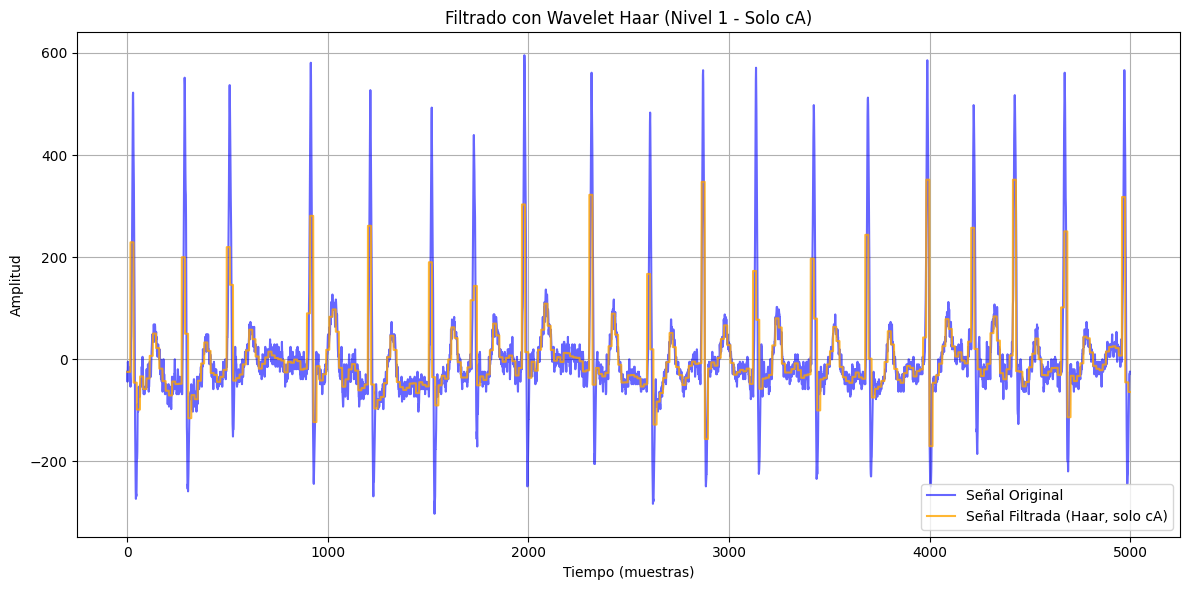

In [6]:
# Parámetros
muestreo_hz = 500
muestras_mostrar = 5000
directorio_parquet = './data/processed_dii/parquet/AFIB'

# Cargar el primer archivo .parquet del directorio
archivos = [f for f in os.listdir(directorio_parquet) if f.endswith('.parquet')]
archivo_parquet = os.path.join(directorio_parquet, archivos[0])

# Leer el archivo .parquet
df = pd.read_parquet(archivo_parquet)
print(f"Archivo cargado: {archivo_parquet}")
print(f"Columnas disponibles: {df.columns}")

# Seleccionar columna de señal ECG
columna_senal = 'II' if 'II' in df.columns else df.columns[0]
senal = df[columna_senal].values[:muestras_mostrar]

# Aplicar descomposición wavelet Haar con nivel
wavelet = 'haar'
nivel = 4  # Puedes cambiar esto a 2, 3, etc. si lo deseas
coeffs = pywt.wavedec(senal, wavelet=wavelet, level=nivel)

# Eliminar detalles (alta frecuencia)
for i in range(1, len(coeffs)):
    coeffs[i] = np.zeros_like(coeffs[i])

# Reconstrucción solo con la aproximación
senal_filtrada = pywt.waverec(coeffs, wavelet)
senal_filtrada = senal_filtrada[:len(senal)]  # Ajustar longitud

# Visualizar
plt.figure(figsize=(12, 6))
plt.plot(senal, label='Señal Original', color='blue', alpha=0.6)
plt.plot(senal_filtrada, label='Señal Filtrada (Haar, solo cA)', color='orange', alpha=0.8)
plt.title('Filtrado con Wavelet Haar (Nivel 1 - Solo cA)')
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#### **3.4** Coiflet (coif3)

Archivo cargado: ./data/processed_dii/parquet/AFIB\MUSE_20180111_155154_74000.parquet
Columnas disponibles: Index(['timestamp', 'II'], dtype='object')


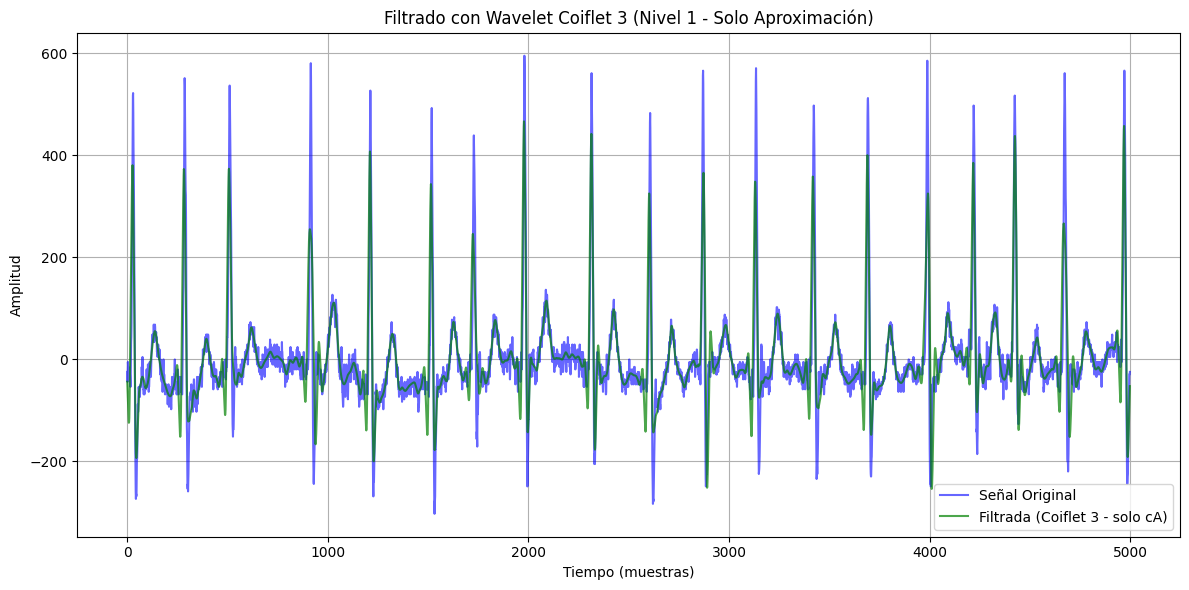

In [7]:
# Parámetros
muestreo_hz = 500
muestras_mostrar = 5000
directorio_parquet = './data/processed_dii/parquet/AFIB'

# Cargar el primer archivo .parquet del directorio
archivos = [f for f in os.listdir(directorio_parquet) if f.endswith('.parquet')]
archivo_parquet = os.path.join(directorio_parquet, archivos[0])

# Leer archivo .parquet
df = pd.read_parquet(archivo_parquet)
print(f"Archivo cargado: {archivo_parquet}")
print(f"Columnas disponibles: {df.columns}")

# Seleccionar columna ECG
columna_senal = 'II' if 'II' in df.columns else df.columns[0]
senal = df[columna_senal].values[:muestras_mostrar]

# Aplicar descomposición wavelet con Coiflet 3
wavelet = 'coif3'
nivel = 4  # Puedes aumentar a 2, 3, etc.
coeffs = pywt.wavedec(senal, wavelet=wavelet, level=nivel)

# Eliminar los detalles (alta frecuencia)
for i in range(1, len(coeffs)):
    coeffs[i] = np.zeros_like(coeffs[i])

# Reconstrucción usando solo la aproximación
senal_filtrada = pywt.waverec(coeffs, wavelet)
senal_filtrada = senal_filtrada[:len(senal)]  # Ajustar longitud por padding

# Visualización
plt.figure(figsize=(12, 6))
plt.plot(senal, label='Señal Original', color='blue', alpha=0.6)
plt.plot(senal_filtrada, label='Filtrada (Coiflet 3 - solo cA)', color='green', alpha=0.7)
plt.title('Filtrado con Wavelet Coiflet 3 (Nivel 1 - Solo Aproximación)')
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#### **3.5** Adaptación filtro mejorado de wavelet Daubechies (db6)

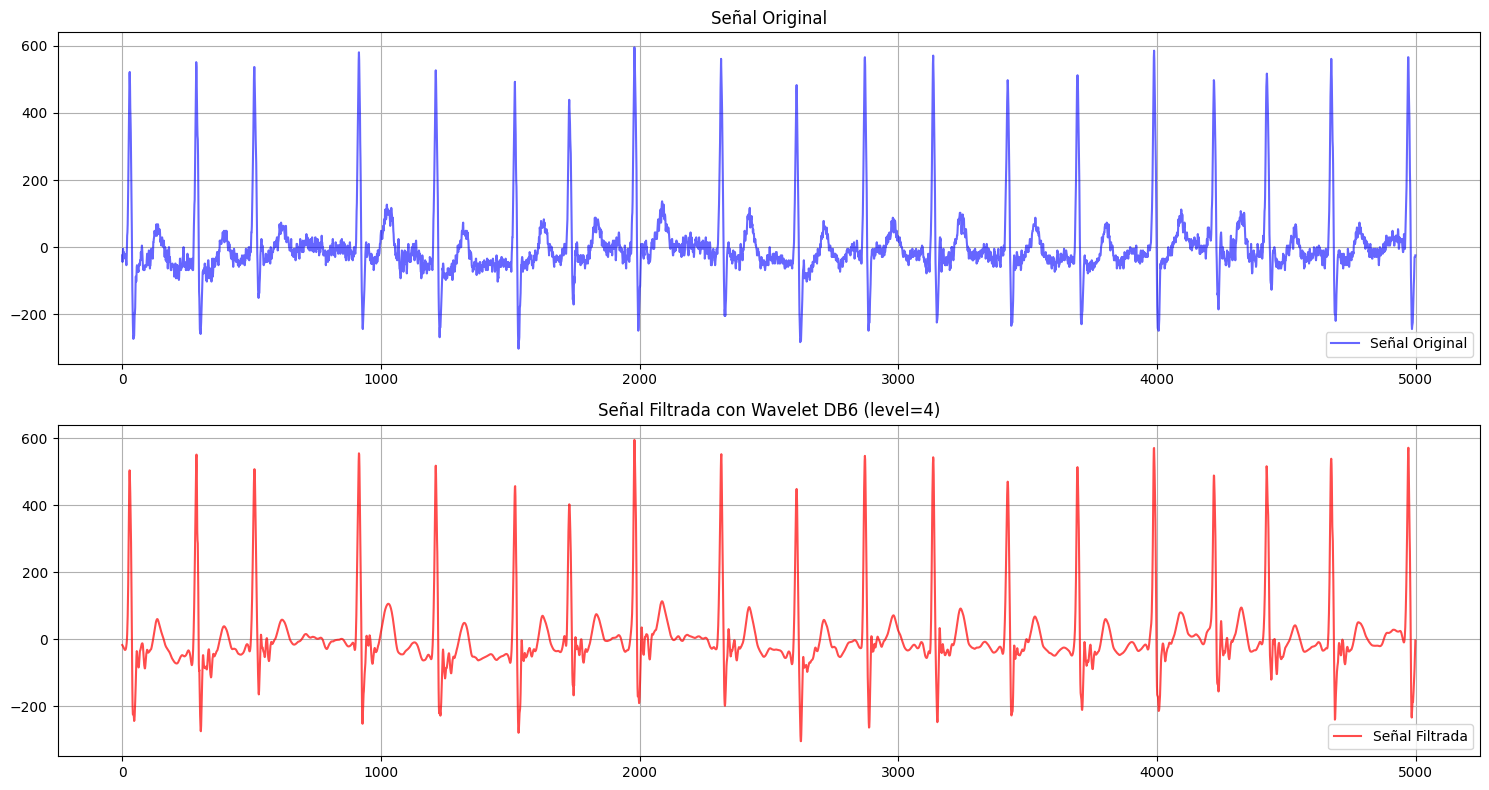

In [8]:

def wnoisest(coeff):
    """Calcula la estimación del ruido para cada nivel de detalle."""
    stdc = np.zeros((len(coeff), 1))
    for i in range(len(coeff)):
        stdc[i] = np.median(np.abs(coeff[i])) / 0.6745
    return stdc

def threshold(coeff):
    num_samples = sum(c.shape[0] for c in coeff)
    thr = np.sqrt(2 * np.log(num_samples))
    return thr

def wthresh(coeff):
    s = wnoisest(coeff)
    thr = threshold(coeff)
    y = [np.multiply(c, np.abs(c) > (thr * s[i])) for i, c in enumerate(coeff)]
    return thr, s, y

def waveletdb6(data, wavelet='db6', level=4, graficar=True):
    # Descomposición wavelet
    data_wavelet = pywt.wavedec(data, wavelet, level=level)
    
    # Extraer detalles y aplicar thresholding
    details = data_wavelet[1:]
    thr, s, details_t = wthresh(details)
    
    # Reconstruir señal
    coeff = [data_wavelet[0]] + details_t
    x_rec = pywt.waverec(coeff, wavelet)
    x_rec = x_rec[:len(data)]  # Ajustar longitud por padding

    # Visualización opcional
    if graficar:
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 1, 1)
        plt.plot(data, label='Señal Original', color='blue', alpha=0.6)
        plt.title('Señal Original')
        plt.grid(True)
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(x_rec, label='Señal Filtrada', color='red', alpha=0.7)
        plt.title(f'Señal Filtrada con Wavelet {wavelet.upper()} (level={level})')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

    return x_rec

# Parámetros
muestreo_hz = 500
muestras_mostrar = 5000
directorio_parquet = './data/processed_dii/parquet/AFIB'

# Buscar y cargar primer archivo .parquet
archivos = [f for f in os.listdir(directorio_parquet) if f.endswith('.parquet')]
archivo_parquet = os.path.join(directorio_parquet, archivos[0])
df = pd.read_parquet(archivo_parquet)

# Obtener la señal (columna II o la primera disponible)
columna_senal = 'II' if 'II' in df.columns else df.columns[0]
senal = df[columna_senal].values[:muestras_mostrar]

# Llamar la función que hicimos
x_filtrada = waveletdb6(senal, wavelet='db6', level=4)

### **4.** Flujos para 10 señales.



In [9]:
# Funciones para los flujos

def filtro_pasaaltas_iir(senal, fs=500, fc=0.5, orden=4):
    w = fc / (fs / 2)  # frecuencia normalizada
    b, a = butter(orden, w, btype='highpass')
    senal_filtrada = filtfilt(b, a, senal)
    return senal_filtrada

#senal_hp = filtro_pasaaltas_iir(senal, fs=500, fc=0.5)


def filtro_pasabajas_iir(senal, fs=500, fc=50, orden=4):
    w = fc / (fs / 2)  # frecuencia normalizada
    b, a = butter(orden, w, btype='lowpass')
    senal_filtrada = filtfilt(b, a, senal)
    return senal_filtrada

#senal_filtrada = filtro_pasabajas_iir(senal_hp, fs=500, fc=50)

def filtro_detrend(senal, tipo='linear'):
    senal_detrend = detrend(senal, type=tipo)
    
    return senal_detrend



#### **4.1** Flujo 1:

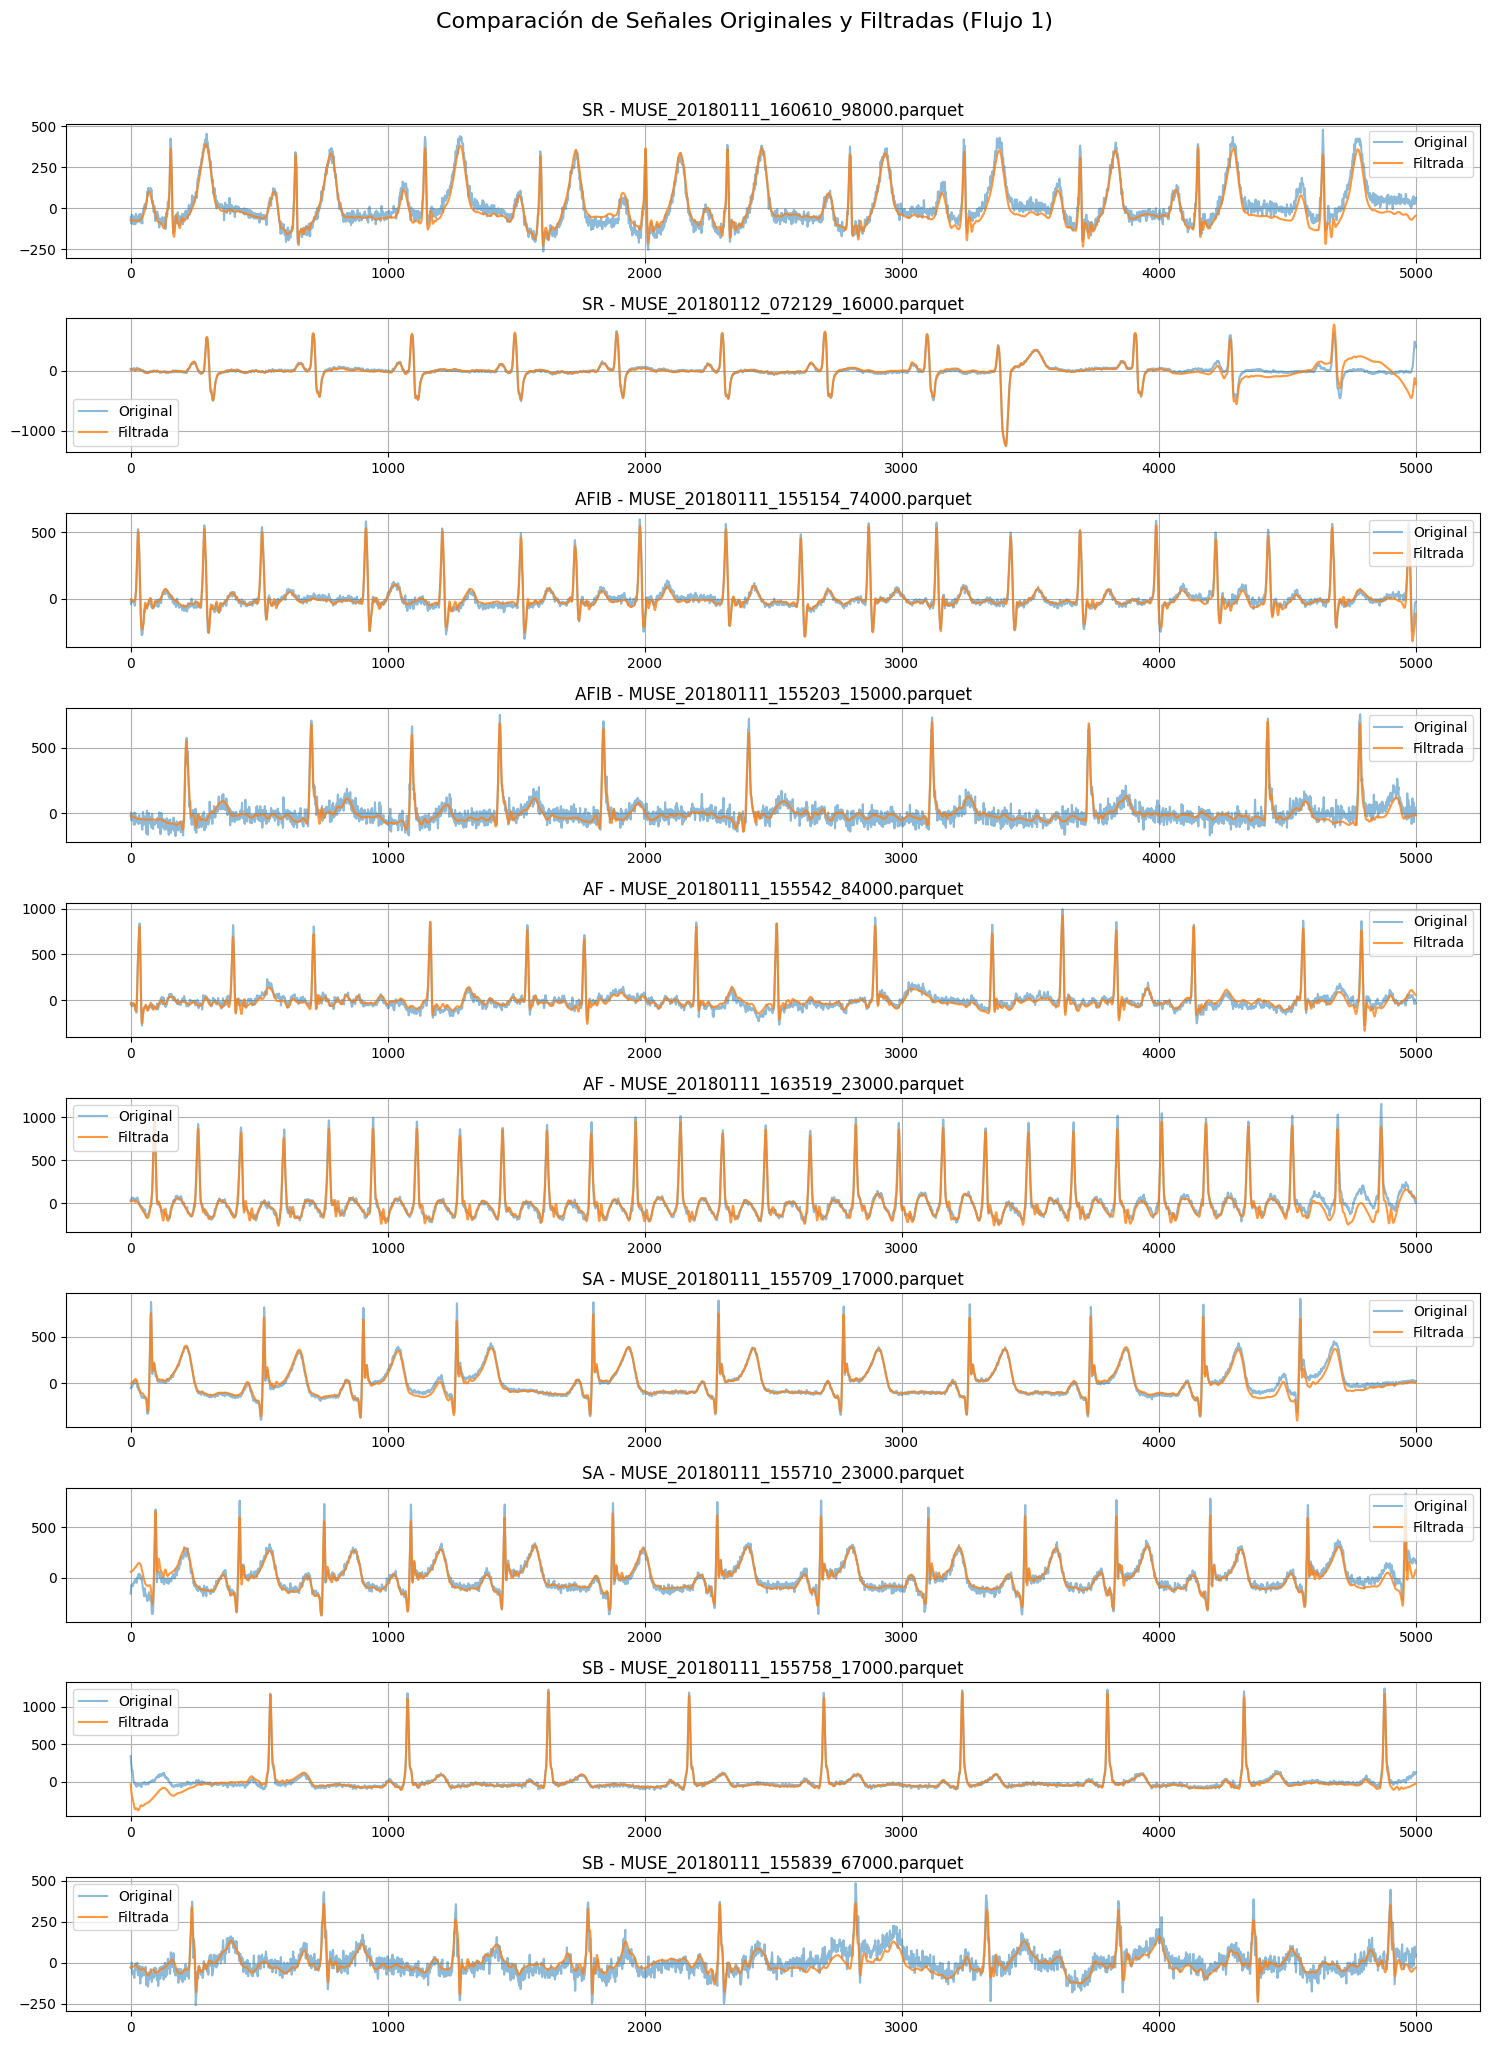

In [10]:
# Flujo 1
def flujo_1(senal, fs):
    senal = filtro_pasaaltas_iir(senal, fs)
    senal = waveletdb6(senal, wavelet='db6', level=4, graficar=False)
    senal = filtro_pasabajas_iir(senal, fs)
    return senal


# Parámetros
muestreo_hz = 500
muestras_mostrar = 5000
arritmias = ['SR', 'AFIB', 'AF', 'SA', 'SB']
base_path = './data/processed_dii/parquet'

senales_procesadas = []
for clase in arritmias:
    clase_path = os.path.join(base_path, clase)
    archivos = [f for f in os.listdir(clase_path) if f.endswith('.parquet')][:2] # 2 archivos por arritmia
    for archivo in archivos:
        archivo_path = os.path.join(clase_path, archivo) #Ruta completa del archivo
        df = pd.read_parquet(archivo_path) # Cargar
        columna_senal = 'II' if 'II' in df.columns else df.columns[0] #Columna de la derivacion II
        senal = df[columna_senal].values[:muestras_mostrar] # se coge las muestras
        #filtrado
        senal_filtrada = flujo_1(senal, muestreo_hz) # Filtro flujo 1
        senales_procesadas.append((clase, archivo, senal, senal_filtrada)) #Guardamos los datos

# Graficar una por clase
plt.figure(figsize=(15, 20))  # Aumenta altura para acomodar 10 gráficas

for i, (clase, archivo, original, filtrada) in enumerate(senales_procesadas[:10]):
    plt.subplot(10, 1, i + 1)
    plt.plot(original, label='Original', alpha=0.5)
    plt.plot(filtrada, label='Filtrada', alpha=0.8)
    plt.title(f'{clase} - {archivo}')
    plt.legend()
    plt.grid(True)

plt.suptitle("Comparación de Señales Originales y Filtradas (Flujo 1)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

#### **4.2** Flujo 2:

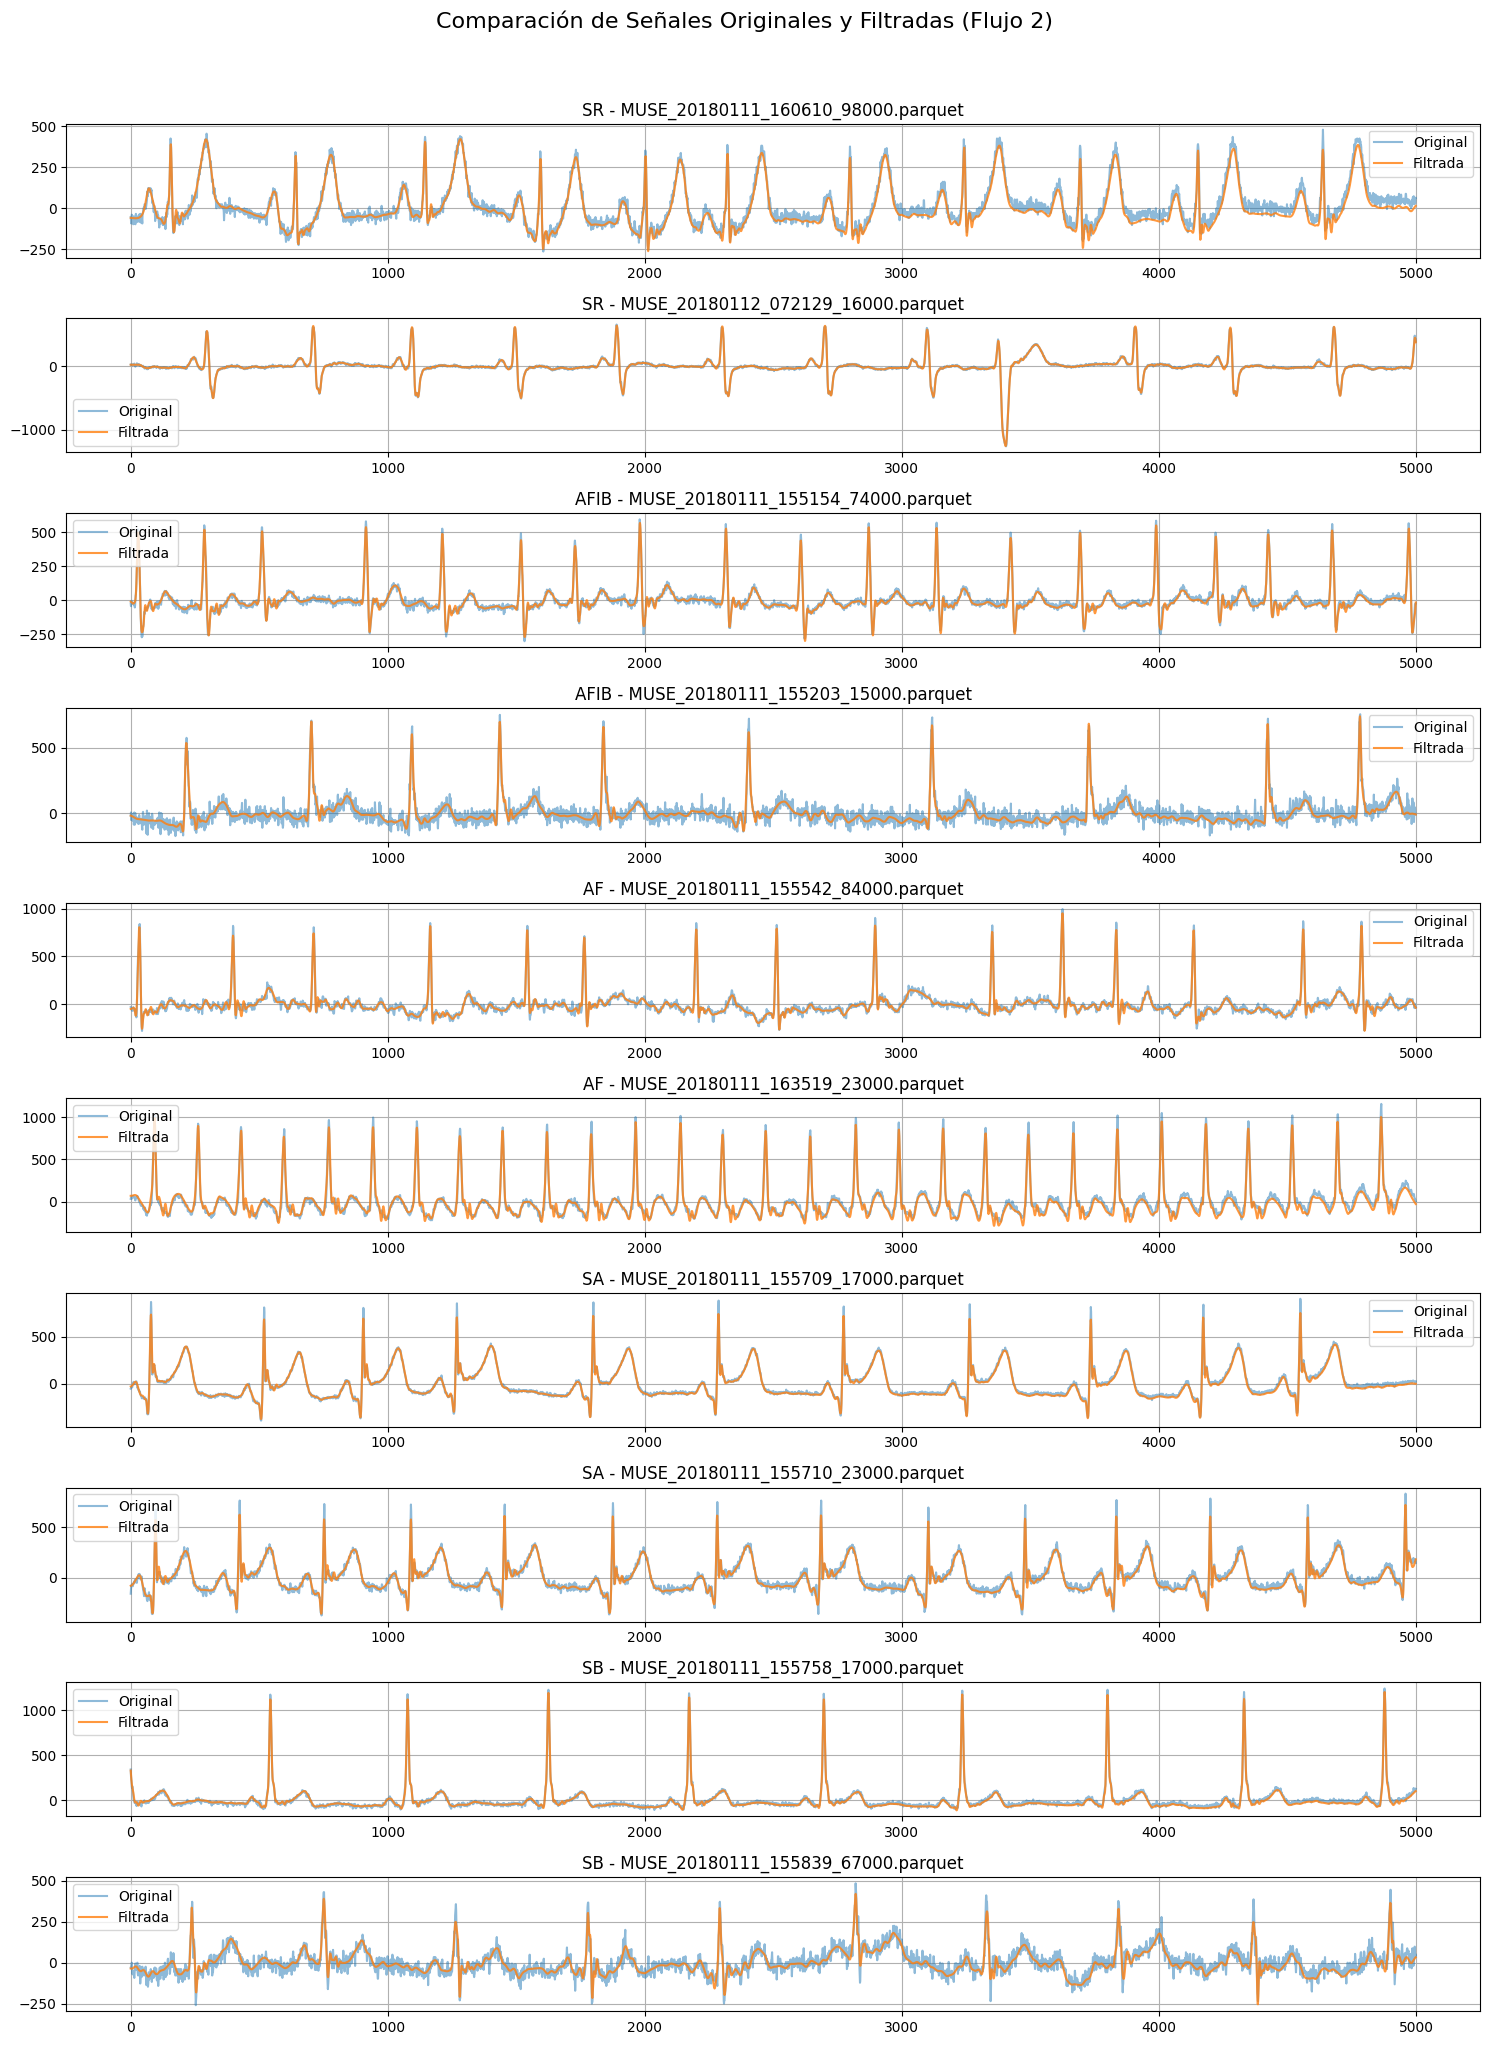

In [11]:
# Flujo 2
def flujo_2(senal, fs):
    senal = filtro_detrend(senal)
    senal = waveletdb6(senal, wavelet='db6', level=4, graficar=False)
    senal = filtro_pasabajas_iir(senal, fs)
    return senal


# Parámetros
muestreo_hz = 500
muestras_mostrar = 5000
arritmias = ['SR', 'AFIB', 'AF', 'SA', 'SB']
base_path = './data/processed_dii/parquet'

senales_procesadas_2 = []
for clase in arritmias:
    clase_path = os.path.join(base_path, clase)
    archivos = [f for f in os.listdir(clase_path) if f.endswith('.parquet')][:2] # 2 archivos por arritmia
    for archivo in archivos:
        archivo_path = os.path.join(clase_path, archivo) #Ruta completa del archivo
        df = pd.read_parquet(archivo_path) # Cargar
        columna_senal = 'II' if 'II' in df.columns else df.columns[0] #Columna de la derivacion II
        senal = df[columna_senal].values[:muestras_mostrar] # se coge las muestras
        #filtrado
        senal_filtrada = flujo_2(senal, muestreo_hz) # Filtro flujo 2
        senales_procesadas_2.append((clase, archivo, senal, senal_filtrada)) #Guardamos los datos

# Graficar una por clase
plt.figure(figsize=(15, 20))  # Aumenta altura para acomodar 10 gráficas

for i, (clase, archivo, original, filtrada) in enumerate(senales_procesadas_2[:10]):
    plt.subplot(10, 1, i + 1)
    plt.plot(original, label='Original', alpha=0.5)
    plt.plot(filtrada, label='Filtrada', alpha=0.8)
    plt.title(f'{clase} - {archivo}')
    plt.legend()
    plt.grid(True)

plt.suptitle("Comparación de Señales Originales y Filtradas (Flujo 2)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

#### **4.3** Flujo 3:

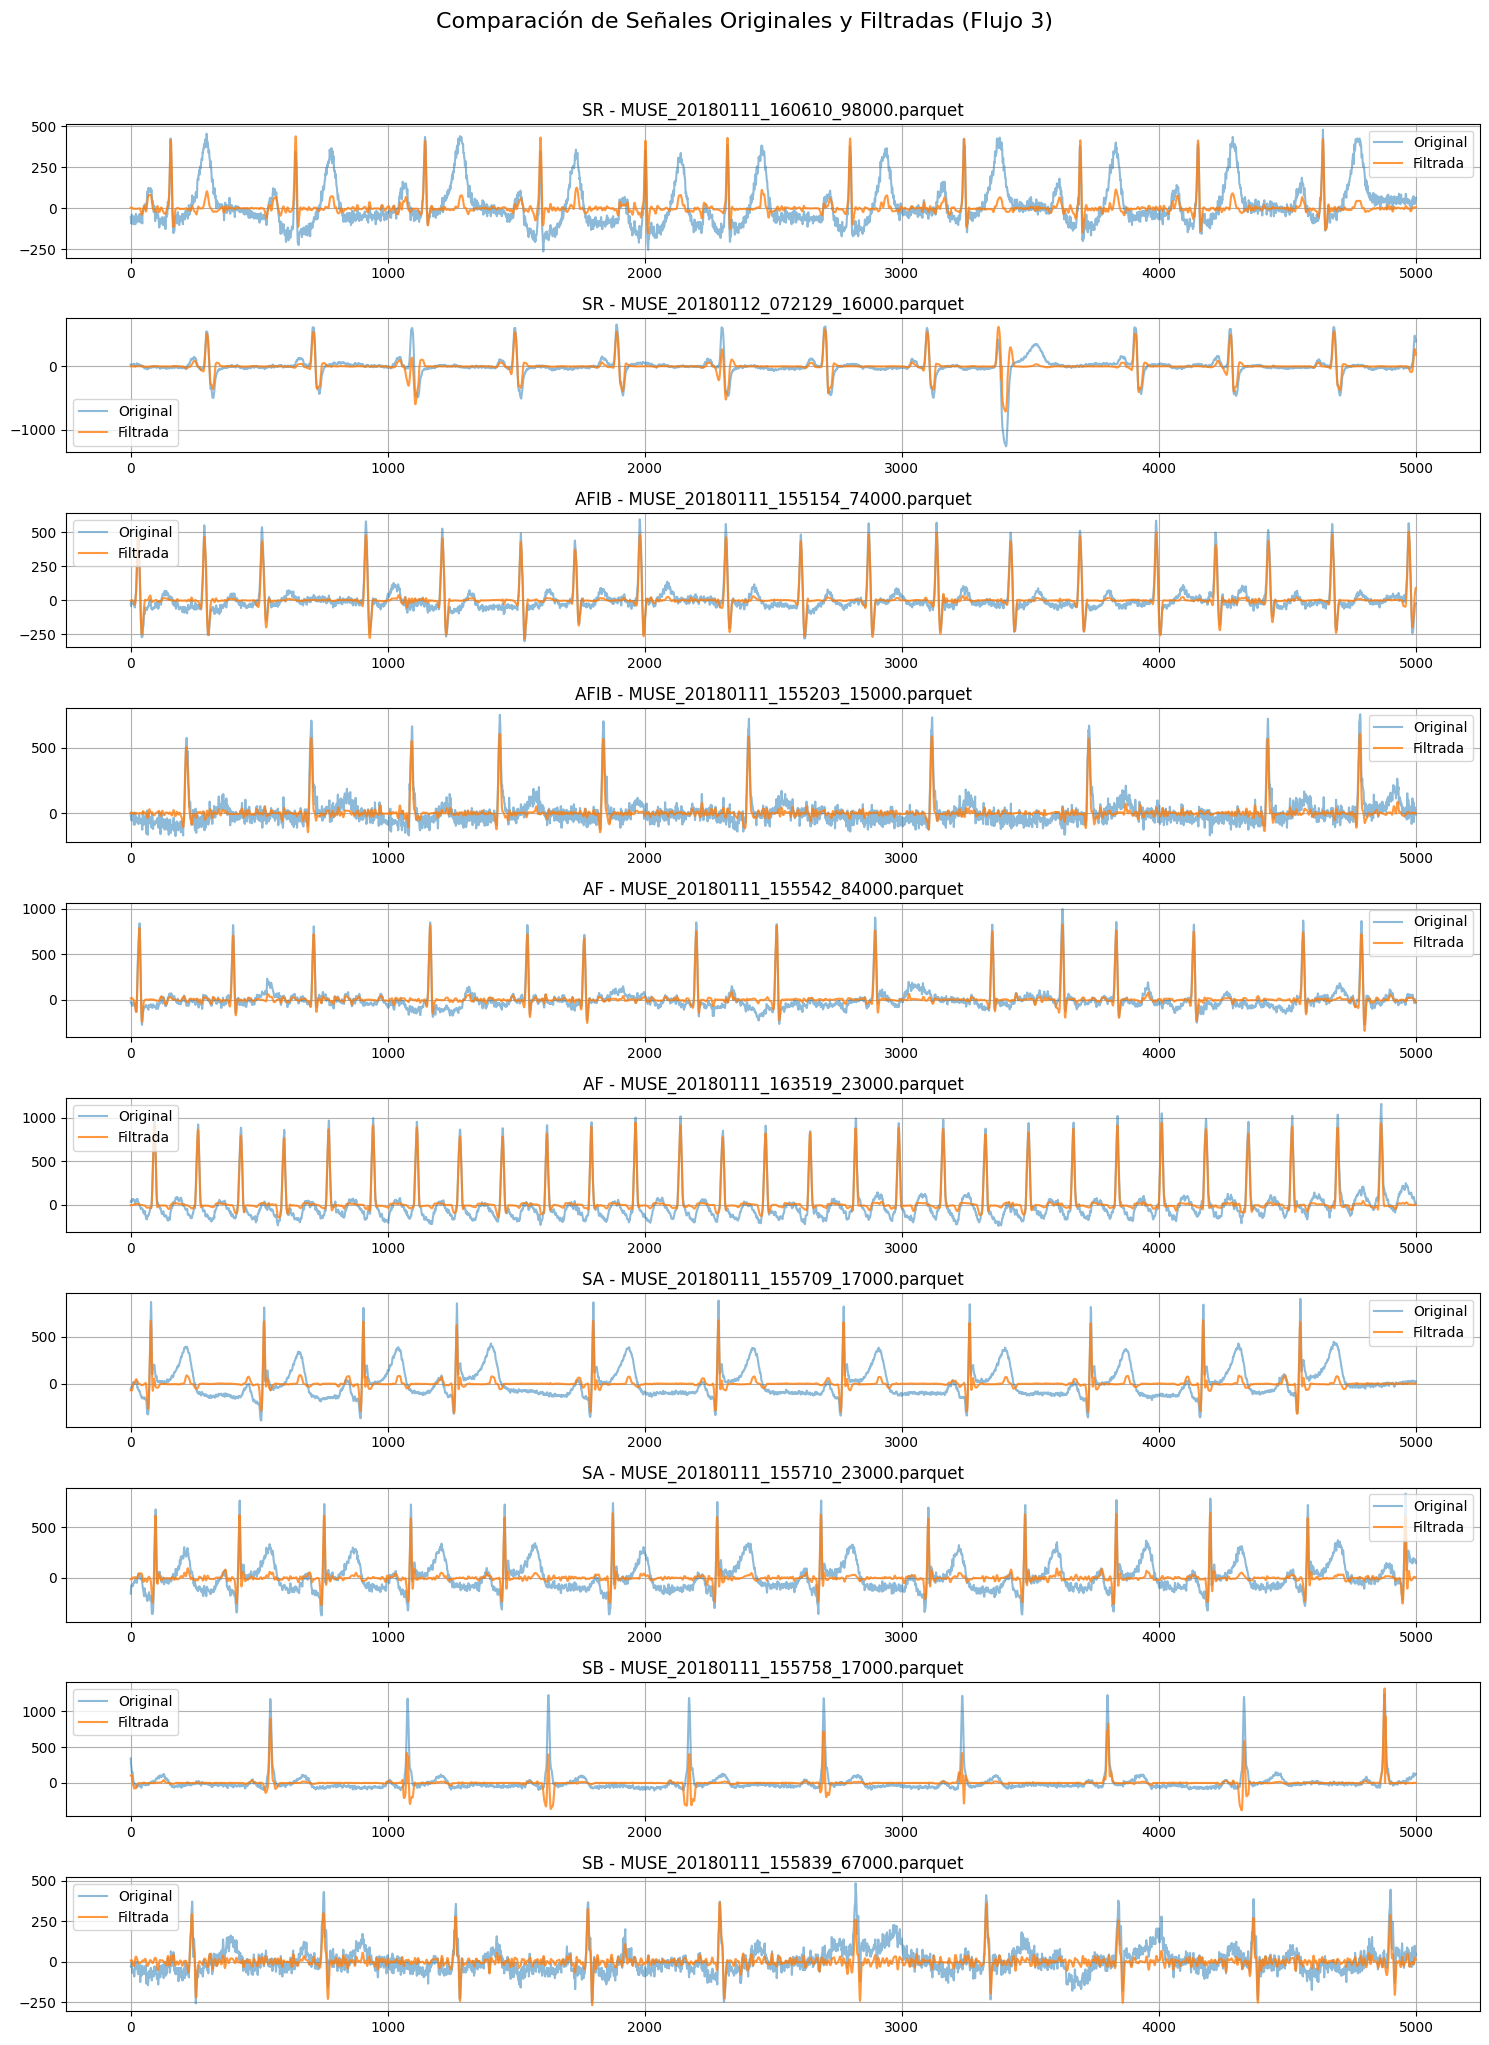

In [12]:
# Flujo 3
def flujo_3(senal, fs):
    senal = filtro_pasabajas_iir(senal, fs)
    senal, _ = filtro_loess(senal)
    senal = nlm_1d(senal, h=0.5 * np.std(senal))
    return senal

# Parámetros
muestreo_hz = 500
muestras_mostrar = 5000
arritmias = ['SR', 'AFIB', 'AF', 'SA', 'SB']
base_path = './data/processed_dii/parquet'

senales_procesadas_3 = []
for clase in arritmias:
    clase_path = os.path.join(base_path, clase)
    archivos = [f for f in os.listdir(clase_path) if f.endswith('.parquet')][:2] # 2 archivos por arritmia
    for archivo in archivos:
        archivo_path = os.path.join(clase_path, archivo) #Ruta completa del archivo
        df = pd.read_parquet(archivo_path) # Cargar
        columna_senal = 'II' if 'II' in df.columns else df.columns[0] #Columna de la derivacion II
        senal = df[columna_senal].values[:muestras_mostrar] # se coge las muestras
        #filtrado
        senal_filtrada = flujo_3(senal, muestreo_hz) # Filtro flujo 3
        senales_procesadas_3.append((clase, archivo, senal, senal_filtrada)) #Guardamos los datos

# Graficar una por clase
plt.figure(figsize=(15, 20))  # Aumenta altura para acomodar 10 gráficas

for i, (clase, archivo, original, filtrada) in enumerate(senales_procesadas_3[:10]):
    plt.subplot(10, 1, i + 1)
    plt.plot(original, label='Original', alpha=0.5)
    plt.plot(filtrada, label='Filtrada', alpha=0.8)
    plt.title(f'{clase} - {archivo}')
    plt.legend()
    plt.grid(True)

plt.suptitle("Comparación de Señales Originales y Filtradas (Flujo 3)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Metrica para definir el mejor flujo:

In [ ]:
resultados_comparacion = []

for i in range(len(senales_procesadas)):
    clase, archivo, original, filtrada1 = senales_procesadas[i]
    _, _, _, filtrada2 = senales_procesadas_2[i]
    _, _, _, filtrada3 = senales_procesadas_3[i]

    min_len = min(len(original), len(filtrada1), len(filtrada2), len(filtrada3))
    original = original[:min_len]
    filtrada1 = filtrada1[:min_len]
    filtrada2 = filtrada2[:min_len]
    filtrada3 = filtrada3[:min_len]

    # RMSE
    rmse1 = np.sqrt(mean_squared_error(original, filtrada1))
    rmse2 = np.sqrt(mean_squared_error(original, filtrada2))
    rmse3 = np.sqrt(mean_squared_error(original, filtrada3))

    # Correlación
    corr1, _ = pearsonr(original, filtrada1)
    corr2, _ = pearsonr(original, filtrada2)
    corr3, _ = pearsonr(original, filtrada3)

    # (RMSE - Correlación)
    score1 = rmse1 - corr1
    score2 = rmse2 - corr2
    score3 = rmse3 - corr3

    # Mejor flujo
    scores = {'flujo1': score1, 'flujo2': score2, 'flujo3': score3}
    mejor_flujo = min(scores, key=scores.get)

    # Resultados
    resultados_comparacion.append({
        'clase': clase,
        'archivo': archivo,

        'RMSE_flujo1': rmse1,
        'Corr_flujo1': corr1,
        'Diferencia_flujo1': score1,

        'RMSE_flujo2': rmse2,
        'Corr_flujo2': corr2,
        'Diferencia_flujo2': score2,

        'RMSE_flujo3': rmse3,
        'Corr_flujo3': corr3,
        'Diferencia_flujo3': score3,

        'mejor_flujo': mejor_flujo
    })

# Tabla
df_resultados = pd.DataFrame(resultados_comparacion)
pd.set_option("display.precision", 4)
print(df_resultados)




  clase                             archivo  RMSE_flujo1  Corr_flujo1  \
0    SR  MUSE_20180111_160610_98000.parquet      41.3725       0.9579   
1    SR  MUSE_20180112_072129_16000.parquet      64.2784       0.9219   
2  AFIB  MUSE_20180111_155154_74000.parquet      23.2820       0.9763   
3  AFIB  MUSE_20180111_155203_15000.parquet      40.6463       0.9253   
4    AF  MUSE_20180111_155542_84000.parquet      38.0713       0.9607   
5    AF  MUSE_20180111_163519_23000.parquet      53.7442       0.9720   
6    SA  MUSE_20180111_155709_17000.parquet      32.8671       0.9813   
7    SA  MUSE_20180111_155710_23000.parquet      42.1297       0.9596   
8    SB  MUSE_20180111_155758_17000.parquet      52.1450       0.9432   
9    SB  MUSE_20180111_155839_67000.parquet      40.8399       0.8590   

   Diferencia_flujo1  RMSE_flujo2  Corr_flujo2  Diferencia_flujo2  \
0            40.4146      31.6501       0.9797            30.6704   
1            63.3565      11.1256       0.9975            

### **5.** Maxima potencia Welch

In [17]:
def potencia_welch(senal, fs=500):
    window = hann(512)
    nperseg = 512   # ancho de la ventana
    noverlap = int(nperseg/2)   # solapamiento de las ventanas
    f, Pxx = welch(senal, fs=fs, window=window, noverlap=noverlap, nfft=1024)
    idx_max = np.argmax(Pxx)
    return f[idx_max], Pxx[idx_max]


muestreo_hz = 500
muestras_mostrar = 5000
arritmias = ['AFIB', 'SB', 'SR', 'ST', 'SVT', 'AF', 'SA','AT', 'AVNRT', 'AVRT', 'SAAWR']
base_path = './data/processed_dii/parquet'

resultados_welch = []

for arritmia in arritmias:
    archivos = glob.glob(f"{base_path}/{arritmia}/*.parquet")

    for archivo in archivos:
        try:
            df = pd.read_parquet(archivo)
            df.columns = ['timestamp', 'ecg_signal']
            ecg = df['ecg_signal'].values[:muestras_mostrar]

            f_max, p_max = potencia_welch(ecg, fs=muestreo_hz)

            resultados_welch.append({
                'arritmia': arritmia,
                'archivo': archivo.split('/')[-1],
                'frecuencia_max': f_max,
                'potencia_max': p_max
            })

        except Exception as e:
            print(f"Error procesando {archivo}: {e}")

# Convertir resultados a DataFrame
df_potencias = pd.DataFrame(resultados_welch)
print(df_potencias)

      arritmia                                   archivo  frecuencia_max  \
0         AFIB   AFIB\MUSE_20180111_155154_74000.parquet          4.3945   
1         AFIB   AFIB\MUSE_20180111_155203_15000.parquet          3.9062   
2         AFIB   AFIB\MUSE_20180111_155903_57000.parquet          2.4414   
3         AFIB   AFIB\MUSE_20180111_155945_02000.parquet          3.4180   
4         AFIB   AFIB\MUSE_20180111_160053_89000.parquet          3.4180   
...        ...                                       ...             ...   
10641    SAAWR  SAAWR\MUSE_20180114_125927_34000.parquet          3.9062   
10642    SAAWR  SAAWR\MUSE_20180115_130314_40000.parquet          3.9062   
10643    SAAWR  SAAWR\MUSE_20180116_124311_28000.parquet          0.9766   
10644    SAAWR  SAAWR\MUSE_20180116_133202_99000.parquet          3.4180   
10645    SAAWR  SAAWR\MUSE_20180119_180042_46000.parquet          0.9766   

       potencia_max  
0          934.9897  
1         1110.3660  
2          692.6545  

In [19]:
df_promedios = df_potencias.groupby('arritmia')[['frecuencia_max', 'potencia_max']].mean().reset_index()
print(df_promedios)


   arritmia  frecuencia_max  potencia_max
0        AF          4.7083     6466.5244
1      AFIB          3.6245     3306.9248
2        AT          4.1766     5427.9278
3     AVNRT          5.3406    11076.9522
4      AVRT          4.8218    16198.1296
5        SA          3.6187     3679.3673
6     SAAWR          2.9994     2967.2981
7        SB          2.9155     2256.3157
8        SR          3.8875     2381.4560
9        ST          5.1503     5016.3726
10      SVT          4.7713    18253.5734


### **6.** Rutina completa (Utilizando flujo 2 y Welch)

In [ ]:
# Flujo completo
def flujo_completo(senal, fs):
    senal = waveletdb6(senal, wavelet='db6', level=4, graficar=False)
    senal = flujo_2(senal, fs)
    fmp, _ = potencia_welch(senal)
    return fmp

# Parámetros
muestreo_hz = 500
muestras_mostrar = 5000
arritmias = ['AFIB', 'SB', 'SR', 'ST', 'SVT', 'AF', 'SA', 'AT', 'AVNRT', 'AVRT', 'SAAWR']
base_path = './data/processed_dii/parquet'

# guardar resultados
datos_fmp = []

# todas las señales de todas las arritmias
for clase in arritmias:
    clase_path = os.path.join(base_path, clase)
    archivos = [f for f in os.listdir(clase_path) if f.endswith('.parquet')]

    for archivo in archivos:
        archivo_path = os.path.join(clase_path, archivo)
        try:
            df = pd.read_parquet(archivo_path)

            columna_senal = 'II' if 'II' in df.columns else df.columns[0]
            senal = df[columna_senal].values[:muestras_mostrar]

            # flujo completo
            fmp = flujo_completo(senal, muestreo_hz)

            # resultado
            datos_fmp.append({
                'registro': archivo,
                'patologia': clase,
                'fmp': fmp
            })
        except Exception as e:
            print(f"Error en archivo {archivo_path}: {e}")

# DataFrame
df_fmp = pd.DataFrame(datos_fmp)
df_fmp.to_excel("frecuencias_maximas.xlsx", index=False)

# Resultados Una por cada clase de arritmia
df_muestra = df_fmp.groupby('patologia').first().reset_index()
print(df_muestra.to_string(justify='center'))

# promedio por arritmia
df_fmp_promedio = df_fmp.groupby('patologia')['fmp'].mean().reset_index()
df_fmp_promedio.rename(columns={'fmp': 'fmp_promedio'}, inplace=True)

# resumen
df_fmp_promedio.to_excel("promedio_fmp_por_arritmia.xlsx", index=False)

# resultados
print("\nPromedio de FMP por arritmia:")
print(df_fmp_promedio.to_string(index=False, justify='center'))

   patologia               registro                 fmp 
0        AF   MUSE_20180111_155542_84000.parquet  3.4180
1      AFIB   MUSE_20180111_155154_74000.parquet  4.3945
2        AT   MUSE_20180111_163147_92000.parquet  5.3711
3     AVNRT   MUSE_20180112_072334_92000.parquet  5.8594
4      AVRT   MUSE_20180116_125256_19000.parquet  4.3945
5        SA   MUSE_20180111_155709_17000.parquet  0.9766
6     SAAWR   MUSE_20180114_065933_39000.parquet  3.9062
7        SB   MUSE_20180111_155758_17000.parquet  3.9062
8        SR   MUSE_20180111_160610_98000.parquet  1.9531
9        ST   MUSE_20180111_155115_19000.parquet  1.9531
10      SVT   MUSE_20180111_155633_99000.parquet  7.3242

Promedio de FMP por arritmia:
patologia  fmp_promedio
     AF       3.9765   
   AFIB       3.2857   
     AT       4.1080   
  AVNRT       5.3406   
   AVRT       4.8218   
     SA       3.4755   
  SAAWR       2.9994   
     SB       2.7302   
     SR       3.8346   
     ST       4.9893   
    SVT       4.5501 

### **7.** Comparación de frecuencia maxima, con señales no filtradas y señales filtradas

In [ ]:
# Flujo completo
def flujo_completo(senal, fs):
    senal = waveletdb6(senal, wavelet='db6', level=4, graficar=False)
    senal = flujo_2(senal, fs)
    fmp, _ = potencia_welch(senal)
    return fmp

# Parámetros
muestreo_hz = 500
muestras_mostrar = 5000
arritmias = ['AFIB', 'SB', 'SR', 'ST', 'SVT', 'AF', 'SA', 'AT', 'AVNRT', 'AVRT', 'SAAWR']
base_path = './data/processed_Denoised_ii/parquet'

# resultados
datos_fmp_filtrada = []

# las señales de todas las arritmias
for clase in arritmias:
    clase_path = os.path.join(base_path, clase)
    archivos = [f for f in os.listdir(clase_path) if f.endswith('.parquet')]

    for archivo in archivos:
        archivo_path = os.path.join(clase_path, archivo)
        try:
            df = pd.read_parquet(archivo_path)

            columna_senal = 'II' if 'II' in df.columns else df.columns[0]
            senal = df[columna_senal].values[:muestras_mostrar]

            # flujo completo
            fmp = flujo_completo(senal, muestreo_hz)

            # Guardar resultado
            datos_fmp_filtrada.append({
                'registro': archivo,
                'patologia': clase,
                'fmp': fmp
            })
        except Exception as e:
            print(f"Error en archivo {archivo_path}: {e}")

# DataFrame
df_fmp_filtrada = pd.DataFrame(datos_fmp_filtrada)
df_fmp_filtrada.to_excel("frecuencias_maximas_filtrada.xlsx", index=False)

# promedio por arritmia
df_fmp_filtrada_promedio = df_fmp_filtrada.groupby('patologia')['fmp'].mean().reset_index()
df_fmp_filtrada_promedio.rename(columns={'fmp': 'fmp_promedio'}, inplace=True)

# resumen
df_fmp_filtrada_promedio.to_excel("promedio_fmp_por_arritmia_filtrada.xlsx", index=False)

# resultados
print("\nPromedio de FMP por arritmia:")
print(df_fmp_filtrada_promedio.to_string(index=False, justify='center'))


Promedio de FMP por arritmia:
patologia  fmp_promedio
     AF       4.2552   
   AFIB       3.9460   
     AT       4.2533   
  AVNRT       4.9744   
   AVRT       4.8218   
     SA       4.2624   
  SAAWR       3.6272   
     SB       3.7766   
     SR       4.6117   
     ST       5.5688   
    SVT       4.4569   


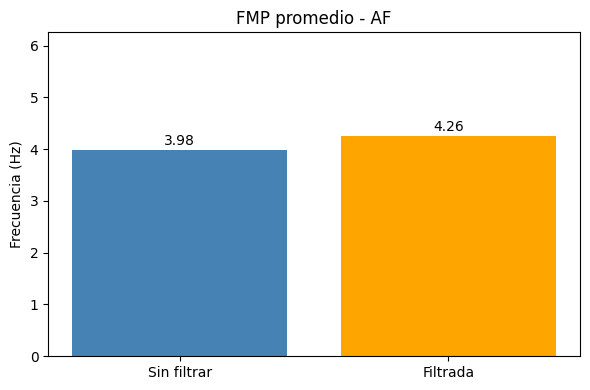

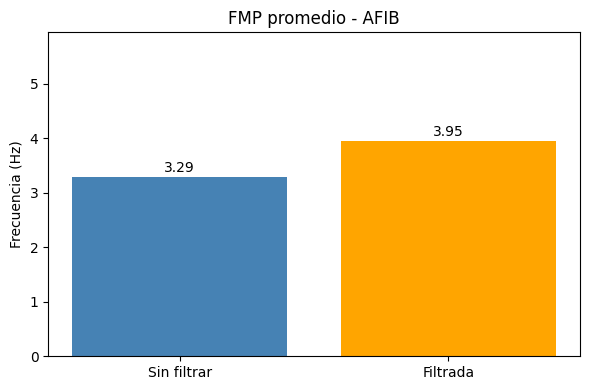

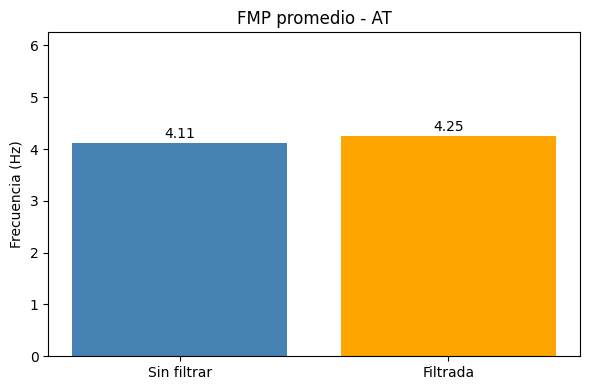

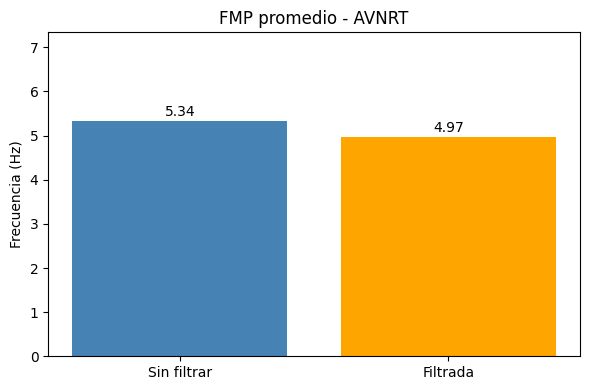

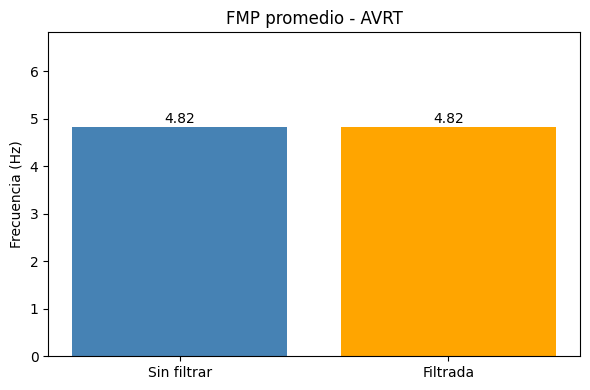

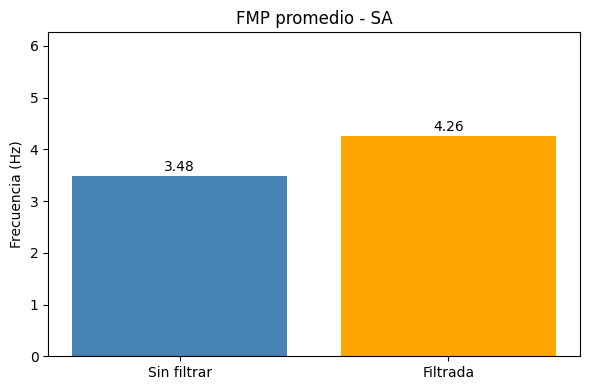

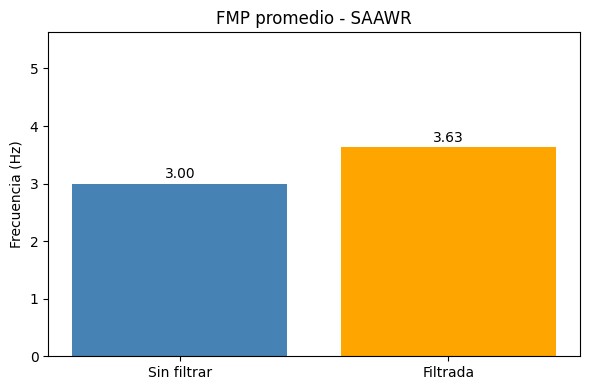

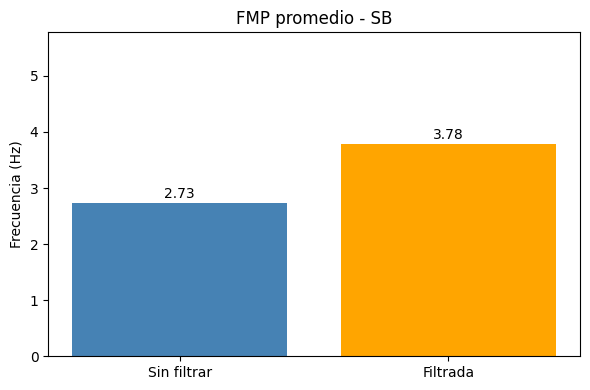

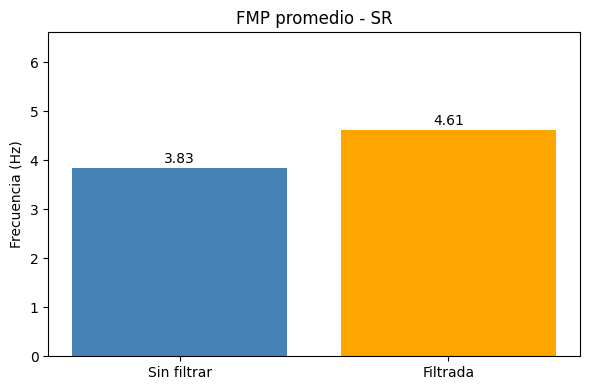

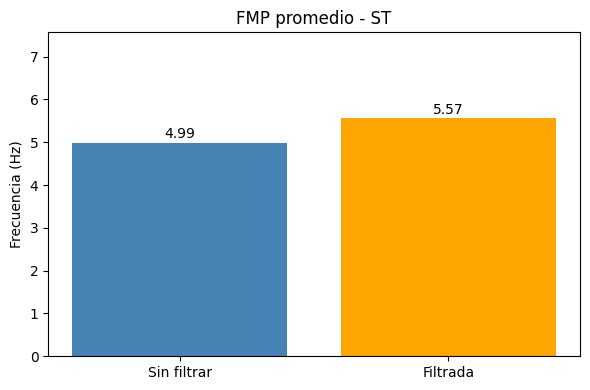

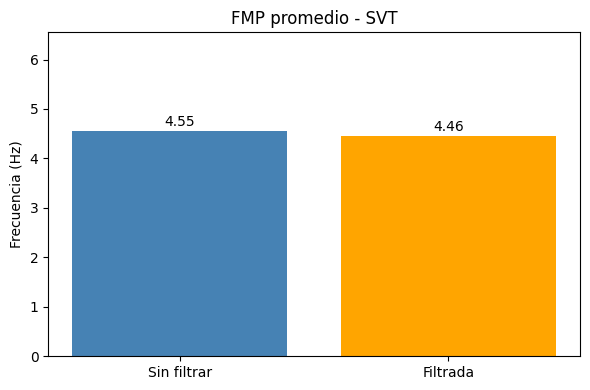

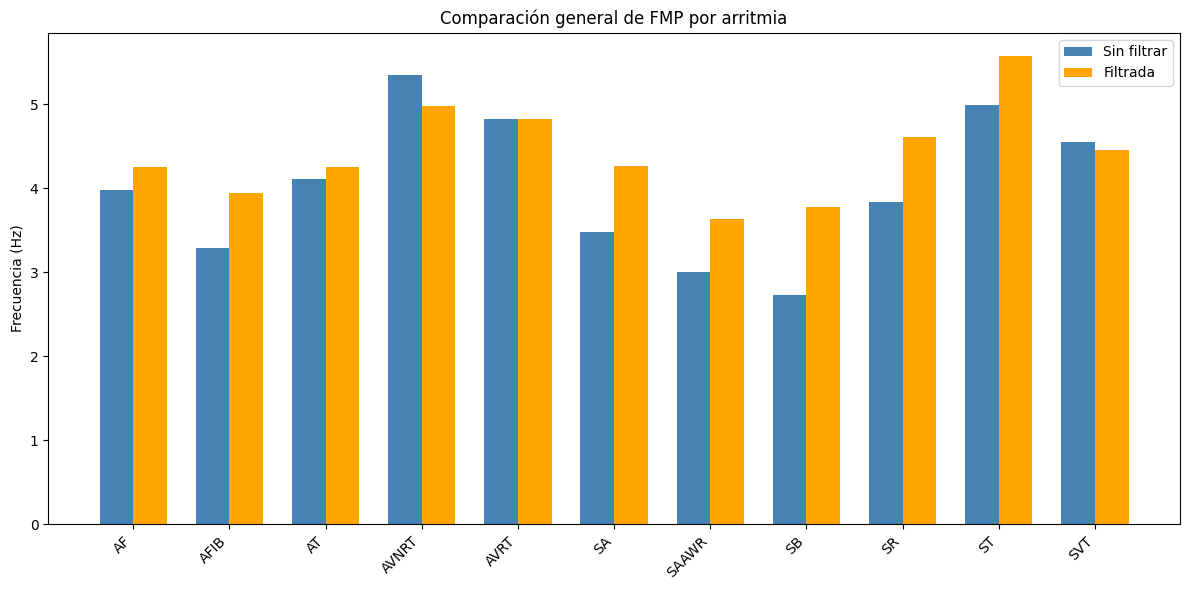

In [ ]:
# Archivos 
df1 = pd.read_excel('promedio_fmp_por_arritmia.xlsx')
df2 = pd.read_excel('promedio_fmp_por_arritmia_filtrada.xlsx')

# columnas 
df1 = df1.rename(columns={'fmp_promedio': 'FMP sin filtrar'})
df2 = df2.rename(columns={'fmp_promedio': 'FMP filtrada'})

# DataFrames por 'patologia'
df_comparado = pd.merge(df1, df2, on='patologia')

# gráfica por arritmia
for _, fila in df_comparado.iterrows():
    arritmia = fila['patologia']
    valores = [fila['FMP sin filtrar'], fila['FMP filtrada']]
    etiquetas = ['Sin filtrar', 'Filtrada']
    
    plt.figure(figsize=(6, 4))
    plt.bar(etiquetas, valores, color=['steelblue', 'orange'])
    plt.title(f'FMP promedio - {arritmia}')
    plt.ylabel('Frecuencia (Hz)')
    plt.ylim(0, max(valores) + 2)  
    
    # Grafico barras
    for i, valor in enumerate(valores):
        plt.text(i, valor + 0.1, f"{valor:.2f}", ha='center')
    
    plt.tight_layout()
    plt.show()

# Gráfica general 
x = np.arange(len(df_comparado)) 
ancho = 0.35  

plt.figure(figsize=(12, 6))

# Barras para FMP sin filtrar
plt.bar(x - ancho/2, df_comparado['FMP sin filtrar'], width=ancho, label='Sin filtrar', color='steelblue')

# Barras para FMP filtrada
plt.bar(x + ancho/2, df_comparado['FMP filtrada'], width=ancho, label='Filtrada', color='orange')

plt.xticks(x, df_comparado['patologia'], rotation=45, ha='right')
plt.ylabel('Frecuencia (Hz)')
plt.title('Comparación general de FMP por arritmia')
plt.legend()
plt.tight_layout()
plt.show()




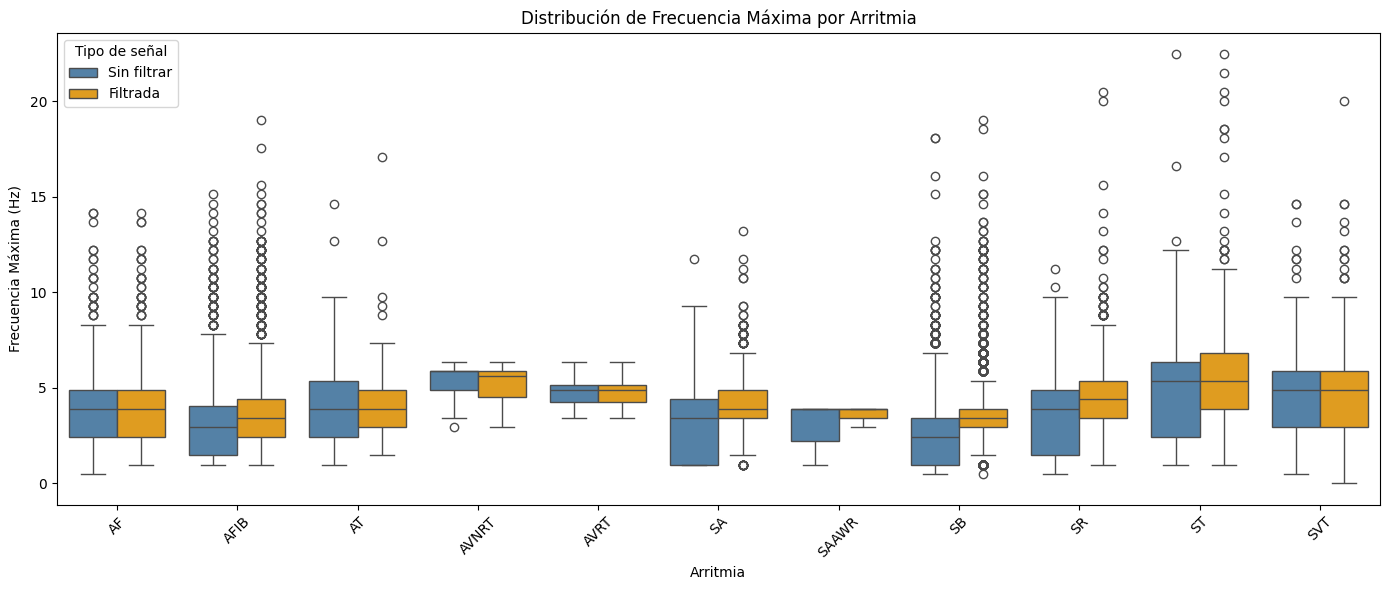

In [ ]:

# archivos
df1 = pd.read_excel("frecuencias_maximas.xlsx")  # Sin filtrar
df2 = pd.read_excel("frecuencias_maximas_filtrada.xlsx")  # Filtrada
columna_fmp = df1.columns[2]  # La tercera columna (frecuencia máxima)
df1['tipo'] = 'Sin filtrar'
df2['tipo'] = 'Filtrada'

# DataFrames
df1 = df1.rename(columns={columna_fmp: 'fmp'})
df2 = df2.rename(columns={columna_fmp: 'fmp'})
df_comb = pd.concat([df1, df2], ignore_index=True)

# boxplot 
plt.figure(figsize=(14, 6))
arritmias_ordenadas = sorted(df_comb['patologia'].unique())

# Gráfico
import seaborn as sns
sns.boxplot(
    data=df_comb,
    x='patologia',
    y='fmp',
    hue='tipo',
    order=arritmias_ordenadas,
    palette={'Sin filtrar': 'steelblue', 'Filtrada': 'orange'}
)

plt.title("Distribución de Frecuencia Máxima por Arritmia")
plt.xlabel("Arritmia")
plt.ylabel("Frecuencia Máxima (Hz)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Tipo de señal")
plt.show()


### Pruebas de hipotesis

In [ ]:
# archivos
df_sin_filtrar = pd.read_excel('frecuencias_maximas.xlsx')
df_filtrada = pd.read_excel('frecuencias_maximas_filtrada.xlsx')
col_fmp = df_sin_filtrar.columns[2]
df_sin_filtrar = df_sin_filtrar.rename(columns={col_fmp: 'fmp'})
df_filtrada = df_filtrada.rename(columns={col_fmp: 'fmp'})

# arritmias
arritmias = sorted(set(df_sin_filtrar['patologia']) & set(df_filtrada['patologia']))

# Nivel de significancia
alpha = 0.05

# Lista resultados
resultados = []

for arr in arritmias:
    grupo1 = df_sin_filtrar[df_sin_filtrar['patologia'] == arr]['fmp'].dropna().values
    grupo2 = df_filtrada[df_filtrada['patologia'] == arr]['fmp'].dropna().values

    grupo1 = grupo1[np.isfinite(grupo1)]
    grupo2 = grupo2[np.isfinite(grupo2)]

    if len(grupo1) < 3 or len(grupo2) < 3:
        resultados.append({
            'arritmia': arr,
            'shapiro1': None,
            'shapiro2': None,
            'levene': None,
            'prueba': 'Insuficiente',
            'p-valor': None,
            'resultado': 'No evaluado'
        })
        continue

    # Normalidad
    _, p1 = shapiro(grupo1)
    _, p2 = shapiro(grupo2)

    # Homocedasticidad
    _, p_levene = levene(grupo1, grupo2)

    # prueba
    if p1 > alpha and p2 > alpha and p_levene > alpha:
        # t-test
        _, p_final = ttest_ind(grupo1, grupo2, equal_var=True)
        prueba = 't-test'
    else:
        # Mann-Whitney
        _, p_final = mannwhitneyu(grupo1, grupo2)
        prueba = 'Mann-Whitney U'

    resultado = 'Diferencia significativa' if p_final < alpha else 'No hay diferencia'

    resultados.append({
        'arritmia': arr,
        'shapiro1': round(p1, 4),
        'shapiro2': round(p2, 4),
        'levene': round(p_levene, 4),
        'prueba': prueba,
        'p-valor': round(p_final, 4),
        'resultado': resultado
    })

# DataFrame
df_resultados = pd.DataFrame(resultados)

# resultados
print(df_resultados.to_string(index=False))



arritmia  shapiro1  shapiro2  levene         prueba  p-valor                resultado
      AF    0.0000    0.0000  0.3096 Mann-Whitney U   0.0327 Diferencia significativa
    AFIB    0.0000    0.0000  0.1865 Mann-Whitney U   0.0000 Diferencia significativa
      AT    0.0000    0.0000  0.3314 Mann-Whitney U   0.6086        No hay diferencia
   AVNRT    0.0004    0.0019  0.2859 Mann-Whitney U   0.4298        No hay diferencia
    AVRT    0.7783    0.7783  1.0000         t-test   1.0000        No hay diferencia
      SA    0.0000    0.0000  0.0000 Mann-Whitney U   0.0000 Diferencia significativa
   SAAWR    0.0015    0.0201  0.2729 Mann-Whitney U   0.7757        No hay diferencia
      SB    0.0000    0.0000  0.0000 Mann-Whitney U   0.0000 Diferencia significativa
      SR    0.0000    0.0000  0.0000 Mann-Whitney U   0.0000 Diferencia significativa
      ST    0.0000    0.0000  0.0001 Mann-Whitney U   0.0000 Diferencia significativa
     SVT    0.0000    0.0000  0.0072 Mann-Whitney U   